# NLP LAB 2

## Ahmed Lachtar
## Yassine Filali

# Text classification with Pytorch

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to IMDB data - and then compare to models implemented in the previous TPs. 

In [ ]:
import torch
import torch.nn as nn

### A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [ ]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([0, 0, 0, 0, 0])
tensor([5])


In [ ]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

In [ ]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [ ]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[0.4642, 0.1885, 0.4918],
        [0.4226, 0.0281, 0.4169]], requires_grad=True)
bias
Parameter containing:
tensor([-0.1892,  0.3434], requires_grad=True)
Initial loss:  1.2289559841156006
dL/dw:  tensor([[ 0.3054,  0.9559,  0.2194],
        [ 0.2265,  0.0727, -0.0288]])
dL/db:  tensor([-0.2847,  0.1277])


In [ ]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  1.217029333114624


In [ ]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  1.2057747840881348


### Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [ ]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [ ]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [ ]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [ ]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [ ]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walk down the city', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down down the boulevard',); labels: tensor([0])
Epoch:1
Batch: ('i walked down the avenue', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down down the boulevard',); labels: tensor([0])
Epoch:2
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walked down down the boulevard',); labels: tensor([0])


### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [ ]:
import os
import sys
from torch.nn import functional as F
import numpy as np
import random

from nltk import word_tokenize
from torch.nn.utils.rnn import pad_sequence

First, we get the filenames and the corresponding categories: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from glob import glob
filenames_neg = sorted(glob(os.path.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'data', 'imdb1', 'pos', '*.txt')))
filenames = filenames_neg + filenames_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
categories = np.ones(len(filenames), dtype=np.int)
categories[:len(filenames_neg)] = 0.

print("%d documents" % len(filenames))

25000 documents


We will need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data. We need to implement a function that will help us split the data in three, according to proportions we give in input.

In [ ]:
# Create a function allowing you to simply shuffle then split the filenames and categories into the desired
# proportions for a training, validation and testing set. 
def get_splits(x, y, splits):
    """
    The idea is to use an index list as reference:
    Indexes = [0 1 2 3 4 5 6 7 8 9]
    To shuffle it randomly:
    Indexes = [7 1 5 0 2 9 8 6 4 3]
    We need 'splits' to contain 2 values. Assuming those are = (0.8, 0.1), we'll have:
    Train_indexes = [7 1 5 0 2 9 8 6]
    Valid_indexes = [4]
    Test_indexes = [3]
    """
    # Create an index list and shuffle it - use the function random.shuffle
    n = len(y)
    index = list(range(n))
    random.shuffle(index)
    
    # Find the two indexes we'll use to cut the lists from the splits
    limit1 = int(n*0.8)
    limit2 = limit1 + int(n*(splits[1]))
    
    # Do the cutting (careful: you can't use a list as index for a list - this only works with tensors)
    # (you need to use list comprehensions - or go through numpy)
    train_x, train_y =  [x[k] for k in index[0:limit1]],[y[k] for k in index[0:limit1]]
    valid_x, valid_y = [x[k] for k in index[limit1:limit2]],[y[k] for k in index[limit1:limit2]]
    test_x, test_y = [x[k] for k in index[limit2:]],[y[k] for k in index[limit2:]]
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
# Choose the training, validation, testing splits
splits = (0.8, 0.1)
(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of path to the IMDB files in the training set: ```path_to_file```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [ ]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [ ]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, paths_to_files, categories, vocab = None, max_length = 100, min_freq = 5):
        # Read all files and put the data in a list of strings

        self.data = [open(f, encoding="utf8").read() for f in paths_to_files] 
        
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        # We then need to tokenize the data .. 
        tokenized_data = [word_tokenize(text) for text in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data =  [[self.word2idx.get(w,len(self.word2idx)) for w in words] for words in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(text) for text in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [w if len(w) <= self.max_length  else torch.narrow(w,0,0,self.max_length) for w in tensor_data]
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value = 0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold=0, voc_threshold=0):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """

        word_counts = {}
        for sent in corpus:
            for word in word_tokenize(sent):
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1    

        filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}   
        words = sorted(filtered_word_counts.keys(), key=word_counts.get, reverse=True)
        if voc_threshold > 0:
            words = words[:voc_threshold] + ['UNK']   
        else :
            words +=  ['UNK'] 
        word_index = {words[i] : i+1 for i in range(len(words))}
        idx_word=dict(zip(word_index.values(), word_index.keys()))     
        
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word


In [ ]:
training_dataset = TextClassificationDataset(train_f, train_c)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [ ]:
valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [ ]:
print(training_dataset[0])

(tensor([ 4244,   891,     1,   276,    23,    16,    14,    36,   146,   127,
            3,   283,    53,   362,   146,   107,     5,  1137,    23,    16,
         2983, 31718,    58,   504,    59,    30,    47,   842,     3,    20,
        31718,  5713,    36,    30,     3,   824, 31718,   482,    13,    80,
          213,  7842, 11491, 13697,   828,   547,   123,  8480,     7,     1,
          205,    16,   106,     6,   847,     8,    93,  1082,   229,    92,
           47,  9773,    11,    12,     9,    10,    11,    12,     9,    10,
           20,   145,   362,  3039,    34,    35, 31718,     4,    34,  1761,
          971,    42,  2641,    11,    12,     9,    10,    11,    12,     9,
           10,  1940, 31718,    17,  5714,     6, 23487,    19,  3927,    11]), tensor(0.))


In [ ]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 100])
torch.Size([200])


### A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [ ]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings =  nn.Embedding(num_embeddings =vocabulary_size+1 , embedding_dim = embedding_dim ,padding_idx = 0)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear =nn.Linear(embedding_dim,1)   
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)  
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        x= torch.mean(x,dim=1,keepdim=False)
        o = self.linear(x).squeeze(dim=1)  
        return o

In [ ]:
import torch.optim as optim

In [ ]:
model = AveragingModel(300, len(training_word2idx))
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model.forward(x) 
        # (2) Compute the loss 
        loss =  criterion(pred,y) 
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()      
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        classes=torch.LongTensor([0 if torch.sigmoid(y)<0.5 else 1 for y in pred])
        num_corrects = sum(np.array(classes==y)) 
        acc = 100.0 * num_corrects/len(y)
        
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

In [ ]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model.forward(x)
            loss = criterion(pred,y) 
            classes=torch.LongTensor([0 if torch.sigmoid(y)<0.5 else 1 for y in pred])
            num_corrects = sum(np.array(classes==y)) 
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [ ]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [ ]:
train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6974214911460876; training acc = 44.0
Batch 20 : training loss = 0.6670205593109131; training acc = 62.5
Batch 40 : training loss = 0.6528061628341675; training acc = 63.0
Batch 60 : training loss = 0.626395046710968; training acc = 70.5
Batch 80 : training loss = 0.5915061831474304; training acc = 73.0
Epoch 1 : Validation loss = 0.5718907168507577; Validation acc = 72.36
Epoch 2:
Batch 0 : training loss = 0.5383198857307434; training acc = 78.0
Batch 20 : training loss = 0.5419949889183044; training acc = 75.0
Batch 40 : training loss = 0.4635448753833771; training acc = 78.5
Batch 60 : training loss = 0.4766266644001007; training acc = 79.5
Batch 80 : training loss = 0.46141695976257324; training acc = 78.0
Epoch 2 : Validation loss = 0.4535519406199455; Validation acc = 79.08
Epoch 3:
Batch 0 : training loss = 0.389078825712204; training acc = 85.5
Batch 20 : training loss = 0.3479170501232147; training acc = 88.5
Batch 40 

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous TP:

In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [ ]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [ ]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(31719, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

In [ ]:
class PretrainedAveragingModel(nn.Module):
    def __init__(self, embeddings,fine_tuning=False):
        super().__init__()
    
        self.fine_tuning=fine_tuning
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=not(fine_tuning),  padding_idx=0)  #
              
         
        self.linear = nn.Linear(embeddings.shape[1],1)   
         
        
    def forward(self, inputs):
        x = self.embeddings(inputs)  
        x= torch.mean(x,dim=1,keepdim=False)
        o = self.linear(x).squeeze(dim=1)   
        return o

In [ ]:
# Model without fine tuning
model_pre_trained = PretrainedAveragingModel(GloveEmbeddings,False)
# optimizer
opt = optim.Adam(model_pre_trained.parameters(), lr=0.0025, betas=(0.9, 0.999))
# binary cross entropy loss 
criterion = nn.BCEWithLogitsLoss()
train_losses = experiment(model_pre_trained, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.694547176361084; training acc = 44.0
Batch 20 : training loss = 0.6841645836830139; training acc = 55.0
Batch 40 : training loss = 0.6754447817802429; training acc = 62.0
Batch 60 : training loss = 0.6552265882492065; training acc = 67.0
Batch 80 : training loss = 0.6662095785140991; training acc = 65.5
Epoch 1 : Validation loss = 0.6496472823619842; Validation acc = 66.4
Epoch 2:
Batch 0 : training loss = 0.6665501594543457; training acc = 60.0
Batch 20 : training loss = 0.6633627414703369; training acc = 59.0
Batch 40 : training loss = 0.6394000053405762; training acc = 67.0
Batch 60 : training loss = 0.6404239535331726; training acc = 62.5
Batch 80 : training loss = 0.6220672726631165; training acc = 68.0
Epoch 2 : Validation loss = 0.6264932757616043; Validation acc = 68.84
Epoch 3:
Batch 0 : training loss = 0.6280421614646912; training acc = 67.5
Batch 20 : training loss = 0.6090697050094604; training acc = 72.5
Batch 40 :

In [ ]:
# Model with fine tuning
model_fine_tuning = PretrainedAveragingModel(GloveEmbeddings,True)
# optimizer
opt = optim.Adam(model_fine_tuning.parameters(),lr=0.0025, betas=(0.9, 0.999))
# binary cross entropy loss 
criterion = nn.BCEWithLogitsLoss()
train_losses = experiment(model_fine_tuning, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6926694512367249; training acc = 54.0
Batch 20 : training loss = 0.6767570376396179; training acc = 65.0
Batch 40 : training loss = 0.6482796669006348; training acc = 69.5
Batch 60 : training loss = 0.6075782775878906; training acc = 72.0
Batch 80 : training loss = 0.5705568790435791; training acc = 73.5
Epoch 1 : Validation loss = 0.5392729312181472; Validation acc = 75.12
Epoch 2:
Batch 0 : training loss = 0.5580908060073853; training acc = 70.5
Batch 20 : training loss = 0.46343526244163513; training acc = 84.0
Batch 40 : training loss = 0.45013195276260376; training acc = 80.5
Batch 60 : training loss = 0.4156688451766968; training acc = 81.5
Batch 80 : training loss = 0.3763042390346527; training acc = 86.5
Epoch 2 : Validation loss = 0.42223505228757857; Validation acc = 80.88
Epoch 3:
Batch 0 : training loss = 0.3281441628932953; training acc = 89.0
Batch 20 : training loss = 0.35497409105300903; training acc = 86.0
Batc

### Questions: 
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
Obviously, we can see that the fine-tuned model performs better than the pre-trained embedding without tuning, where the test accuracy is 72.2% for the pre-trained model, and 82.92% for the fine-tuned model. Also, we can see that the loss is decreasing at a significantly slower rate for the pre-trained model, which is due to the fact that we aren't fine-tuning the pre-trained embedding.

- Make hypothesis based on your intuition and the class on how
    - the number of documents (take only a portion of the 25.000 documents !)
  The number of documents affects the accuracy of the first and third model if it's low, but the second model will have an almost constant performance.
    - the size of the vocabulary (change the minimum frequency of words to be taken in the vocabulary ! )
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify your hypothesis with experiments and analyze your results !

In [ ]:
import matplotlib.pyplot as plt

def experiment_with_number_of_document(number_of_files=100, min_freq=2,num_epochs = 5, early_stopping = True):
    #We repeat the same process fro data preparation as we did in the first part
    training_dataset = TextClassificationDataset(train_f[:number_of_files], train_c[:number_of_files],min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    #Here we use the model without pre-training
    model = AveragingModel(300, len(training_word2idx))
    #optimizer
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    # binary cross entropy loss 
    criterion = nn.BCEWithLogitsLoss()
    # We train the model for 10 epochs
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)


    return test_acc,number_of_files

In [ ]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model.forward(x) 
        # (2) Compute the loss 
        loss =  criterion(pred,y) 
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()      
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        classes=torch.LongTensor([0 if torch.sigmoid(y)<0.5 else 1 for y in pred])
        num_corrects = sum(np.array(classes==y)) 
        acc = 100.0 * num_corrects/len(y)
    return losses

In [ ]:
accuracy=[]
sizes = []
for nb_files in [10,100,200,500]+[k*1000 for k in range(1,26,3)] : 
    print("Training with number of documents = ",nb_files)
    acc, size = experiment_with_number_of_document(nb_files)
    accuracy.append(acc)
    sizes.append(size)

    
plt.plot(sizes, accuracy)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for non pre-trained model")
plt.show()

Training with number of documents =  10
Training with number of documents =  100
Training with number of documents =  200
Training with number of documents =  500
Training with number of documents =  1000
Training with number of documents =  4000
Training with number of documents =  7000
Training with number of documents =  10000
Training with number of documents =  13000
Training with number of documents =  16000
Training with number of documents =  19000
Training with number of documents =  22000
Training with number of documents =  25000


NameError: name 'res_size' is not defined

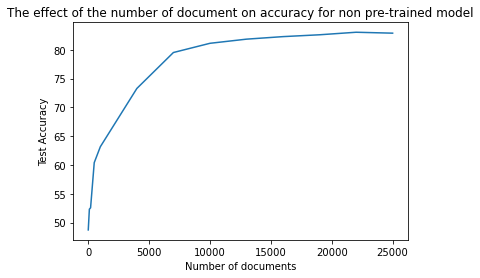

In [ ]:
plt.plot(sizes, accuracy)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for non pre-trained model")
plt.show()

In [ ]:
def experiment_with_number_of_document2(number_of_files=100, min_freq=2,num_epochs = 5, early_stopping = True):
    #We repeat the same process fro data preparation as we did in the first part
    training_dataset = TextClassificationDataset(train_f[:number_of_files], train_c[:number_of_files],min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    #Here we use the Glove model with fine-tuning
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model = PretrainedAveragingModel(GloveEmbeddings,False)
    #optimizer
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    # binary cross entropy loss 
    criterion = nn.BCEWithLogitsLoss()
    # We train the model for 10 epochs
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)


    return test_acc,number_of_files

Training with number of documents =  10
Training with number of documents =  100
Training with number of documents =  200
Training with number of documents =  500
Training with number of documents =  1000
Training with number of documents =  4000
Training with number of documents =  7000
Training with number of documents =  10000
Training with number of documents =  13000
Training with number of documents =  16000
Training with number of documents =  19000
Training with number of documents =  22000
Training with number of documents =  25000


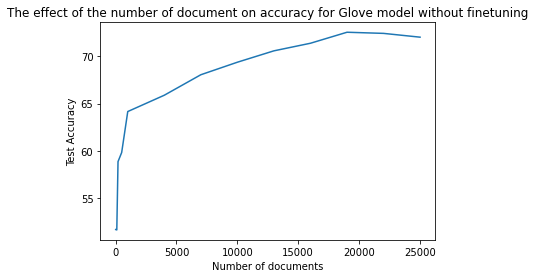

In [ ]:
accuracy=[]
sizes = []
for nb_files in [10,100,200,500]+[k*1000 for k in range(1,26,3)] : 
    print("Training with number of documents = ",nb_files)
    acc, size = experiment_with_number_of_document2(nb_files)
    accuracy.append(acc)
    sizes.append(size)

    
plt.plot(sizes, accuracy)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for Glove model without finetuning")
plt.show()

In [ ]:
def experiment_with_number_of_document2(number_of_files=100, min_freq=2,num_epochs = 5, early_stopping = True):
    #We repeat the same process fro data preparation as we did in the first part
    training_dataset = TextClassificationDataset(train_f[:number_of_files], train_c[:number_of_files],min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    #Here we use the Glove model with fine-tuning
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model = PretrainedAveragingModel(GloveEmbeddings,False)
    #optimizer
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    # binary cross entropy loss 
    criterion = nn.BCEWithLogitsLoss()
    # We train the model for 10 epochs
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)


    return test_acc,number_of_files

Training with number of documents =  10
Training with number of documents =  100
Training with number of documents =  200
Training with number of documents =  500
Training with number of documents =  1000
Training with number of documents =  4000
Training with number of documents =  7000
Training with number of documents =  10000
Training with number of documents =  13000
Training with number of documents =  16000
Training with number of documents =  19000
Training with number of documents =  22000
Training with number of documents =  25000


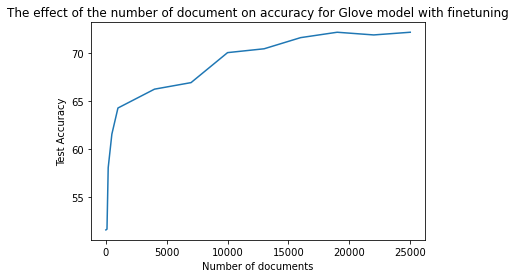

In [ ]:
accuracy=[]
sizes = []
for nb_files in [10,100,200,500]+[k*1000 for k in range(1,26,3)] : 
    print("Training with number of documents = ",nb_files)
    acc, size = experiment_with_number_of_document2(nb_files)
    accuracy.append(acc)
    sizes.append(size)

    
plt.plot(sizes, accuracy)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for Glove model with finetuning")
plt.show()

In [ ]:
# Comments

# Effect of the vocabulary size
We do the same process but changing the vocabulary size and keeping the same number of documents.

In [ ]:
def experiment_with_vocab_size(minimum_frequency, min_freq=2,num_epochs = 5, early_stopping = True):
    #We repeat the same process fro data preparation as we did in the first part
    training_dataset = TextClassificationDataset(train_f, train_c,min_freq = minimum_frequency)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    #Here we use the model without pre-training
    model = AveragingModel(300, len(training_word2idx))
    #optimizer
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    # binary cross entropy loss 
    criterion = nn.BCEWithLogitsLoss()
    # We train the model for 10 epochs
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)


    return test_acc,minimum_frequency

Training with vocabulary size =  25000
Training with vocabulary size =  25000
Training with vocabulary size =  25000
Training with vocabulary size =  25000
Training with vocabulary size =  25000
Training with vocabulary size =  25000
Training with vocabulary size =  25000
Training with vocabulary size =  25000


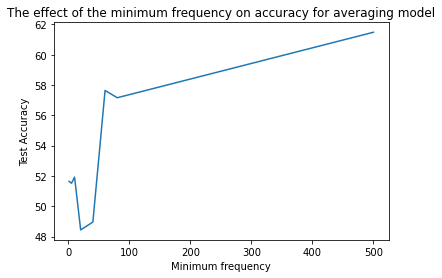

In [ ]:
accuracy=[]
sizes = []
for min_freq in [1,5,10]+[k*10 for k in range(2,10,2)]+ [500]: 
    print("Training with vocabulary size = ",min_freq)
    acc, size = experiment_with_number_of_document2(min_freq)
    accuracy.append(acc)
    sizes.append(size)

    
plt.plot(sizes, accuracy)
plt.xlabel('Minimum frequency')
plt.ylabel('Test Accuracy')
plt.title("The effect of the minimum frequency on accuracy for averaging model")
plt.show()

In [ ]:
def experiment_with_vocab_size(minimum_frequency, min_freq=2,num_epochs = 5, early_stopping = True):
    #We repeat the same process fro data preparation as we did in the first part
    training_dataset = TextClassificationDataset(train_f, train_c,min_freq = minimum_frequency)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    #Here we use the Glove model with fine-tuning
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model = PretrainedAveragingModel(GloveEmbeddings,False)
    #optimizer
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    # binary cross entropy loss 
    criterion = nn.BCEWithLogitsLoss()
    # We train the model for 10 epochs
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)


    return test_acc,minimum_frequency

Training with vocabulary size =  1
Training with vocabulary size =  5
Training with vocabulary size =  10
Training with vocabulary size =  20
Training with vocabulary size =  40
Training with vocabulary size =  60
Training with vocabulary size =  80
Training with vocabulary size =  500


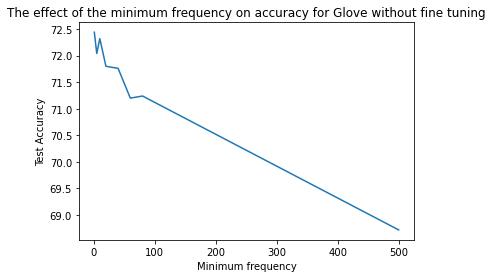

In [ ]:
accuracy=[]
sizes = []
for min_freq in [1,5,10]+[k*10 for k in range(2,10,2)]+ [500]: 
    print("Training with vocabulary size = ",min_freq)
    acc, size = experiment_with_vocab_size(min_freq)
    accuracy.append(acc)
    sizes.append(size)

    
plt.plot(sizes, accuracy)
plt.xlabel('Minimum frequency')
plt.ylabel('Test Accuracy')
plt.title("The effect of the minimum frequency on accuracy for Glove without fine tuning")
plt.show()

In [ ]:
def experiment_with_vocab_size(minimum_frequency, min_freq=2,num_epochs = 5, early_stopping = True):
    #We repeat the same process fro data preparation as we did in the first part
    training_dataset = TextClassificationDataset(train_f, train_c,min_freq = minimum_frequency)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    #Here we use the Glove model without fine-tuning
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model = PretrainedAveragingModel(GloveEmbeddings,True)
    #optimizer
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    # binary cross entropy loss 
    criterion = nn.BCEWithLogitsLoss()
    # We train the model for 10 epochs
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    
    for e in range(num_epochs):
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)


    return test_acc,minimum_frequency

Training with vocabulary size =  1
Training with vocabulary size =  5
Training with vocabulary size =  10
Training with vocabulary size =  20
Training with vocabulary size =  40
Training with vocabulary size =  60
Training with vocabulary size =  80
Training with vocabulary size =  500


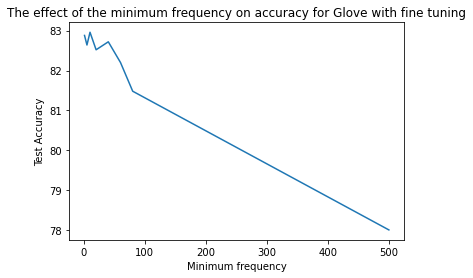

In [ ]:
accuracy=[]
sizes = []
for min_freq in [1,5,10]+[k*10 for k in range(2,10,2)]+ [500]: 
    print("Training with vocabulary size = ",min_freq)
    acc, size = experiment_with_vocab_size(min_freq)
    accuracy.append(acc)
    sizes.append(size)

    
plt.plot(sizes, accuracy)
plt.xlabel('Minimum frequency')
plt.ylabel('Test Accuracy')
plt.title("The effect of the minimum frequency on accuracy for Glove with fine tuning")
plt.show()

### LSTM Cells in pytorch

In [ ]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one lement)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 4.9745e-01, -7.7589e-02,  3.0697e-01]],

        [[ 9.1300e-02, -8.0655e-02,  2.9346e-01]],

        [[-4.8929e-02,  1.0006e-01, -1.0676e-02]],

        [[ 8.1007e-02,  2.5498e-04,  7.5785e-02]],

        [[-1.0801e-02, -4.6589e-02,  8.1466e-02]]], grad_fn=<StackBackward>)
(tensor([[[-0.0108, -0.0466,  0.0815]]], grad_fn=<StackBackward>), tensor([[[-0.0297, -0.2291,  0.1500]]], grad_fn=<StackBackward>))


### Creating our own LSTM Model

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, no_fine_tuning=False):
        super().__init__()
        if embeddings is None: 
            self.embeddings= nn.Embedding(num_embeddings = vocabulary_size + 1 , embedding_dim = embedding_dim)
        else:
            self.embeddings= nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=no_fine_tuning,  padding_idx=0)           
        
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim,1)      

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x,h = self.LSTM(x)
        o = self.linear(h[0]).squeeze()
        return o  

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, no_fine_tuning=False):
        super().__init__()
        if embeddings is None: 
            self.embeddings= nn.Embedding(num_embeddings = vocabulary_size + 1 , embedding_dim = embedding_dim)
        else:
            self.embeddings= nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=no_fine_tuning,  padding_idx=0)           
        
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim,1)      

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x,h = self.LSTM(x)
        o = self.linear(h[0]).squeeze()
        return o  

### And with a CNN ? 

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, embedding_dim=300, vocabulary_size=0,embeddings=None, window_size: int = 16,no_fine_tuning=False, filter_multiplier = 64,sentence_length = 100
                 ,):
        # A compléter
        super().__init__()
        if embeddings is None: 
            self.embeddings= nn.Embedding(num_embeddings = vocabulary_size + 1 , embedding_dim = embedding_dim)
        else:
            self.embeddings= nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=no_fine_tuning,  padding_idx=0) 
        self.convolution = nn.Conv1d(in_channels=embedding_dim, out_channels=filter_multiplier, kernel_size=window_size,bias=True)
        self.maxpooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.linear = nn.Linear(filter_multiplier * ((sentence_length - window_size + 1) // 2),1)
        
    def forward(self, inputs): 
        # A compléter
        x = self.embeddings(inputs)  
        x = self.convolution(torch.transpose(x, 1, 2))  
        x = torch.relu(x)
        x = self.maxpooling(x)
        x =torch.flatten(x,1)
        o = self.linear(x).squeeze(dim=1) 
        return o

In [ ]:
model_CNN = CNNModel(256, len(training_word2idx),None)
# optimizer
opt = optim.Adam(model_CNN.parameters(),lr=0.0025, betas=(0.9, 0.999))
# binary cross entropy loss  
criterion = nn.BCEWithLogitsLoss()
train_losses = experiment(model_CNN, opt, criterion)

Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.6167683216929436; Validation acc = 65.36
Epoch 2:
Epoch 2 : Validation loss = 0.6338418108224869; Validation acc = 71.44
Early stopping.
Epoch 2 : Test loss = 0.6176056364178657; Test acc = 71.64


### Questions: 
- What do you see with a simple application of LSTMs and CNNs models ? 

**A**


We see that the simple averaging model performs better than both simple applications of LSTM and CNN, both not using pre-trained embedding.
- Similarly, make hypothesis based on your intuition and the class on how
    - the number of documents 
    - the size of the vocabulary 
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning) for the LSTM **or** CNN (and the CNN should be quite faster !) and verify your hypothesis with experiments and analyze your results !

**B**

We make the same assumptions as previously, where more documents and larger vocabulary are likely to improve the averaging model and the fine-tuned model, and the non fite-tuned one is unaffected.

- Present your results in a clear and synthetic way (table, figures) and be careful to experimental methodology. Notably, you should fix hyperparameters before making comparisons (you should use maximum length of sentences and batch sizes to accelerate training - similarly, using a SGD optimizer will be faster than Adam) ! 

## Number of documents

In this part, we will see the impact of varying the number of documents used on the performance of our models.

### Not pre-trained model

In [ ]:
def doc_compare(number_of_files, min_freq=2,num_epochs = 5, early_stopping = True):
    
    training_dataset = TextClassificationDataset(train_f[:number_of_files], train_c[:number_of_files],min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    print("vocabulary size : ",len(training_word2idx))
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    
    model =  CNNModel(256, len(training_word2idx),None)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999)) 
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))


    return test_acc,number_of_files

In [ ]:
res_acc=[]
res_size = []
for nb_files in [100,1000,5000,10000,15000,20000,25000] : 
    print("Number of documents : ",nb_files)
    acc, size = doc_compare(nb_files)
    res_acc.append(acc)
    res_size.append(size)

Number of documents :  100
vocabulary size :  1886
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 1.8166296100616455; Validation acc = 50.24
Epoch 2:
Epoch 2 : Validation loss = 0.7294341427087784; Validation acc = 50.44
Epoch 3:
Epoch 3 : Validation loss = 0.7008025515079498; Validation acc = 51.8
Epoch 4:
Epoch 4 : Validation loss = 0.7431658148765564; Validation acc = 51.24
Early stopping.
Epoch 4 : Test loss = 0.7535910212993622; Test acc = 49.36
Number of documents :  1000
vocabulary size :  10879
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.7068175393342971; Validation acc = 51.08
Epoch 2:
Epoch 2 : Validation loss = 0.7379214060306549; Validation acc = 51.24
Early stopping.
Epoch 2 : Test loss = 0.7397968709468842; Test acc = 51.0
Number of documents :  5000
vocabulary size :  28203
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.6935238599777221; Validation acc = 52.8
Epoch 2:
Epoch 2 : Validation loss = 0.7910275721549987; Validation ac

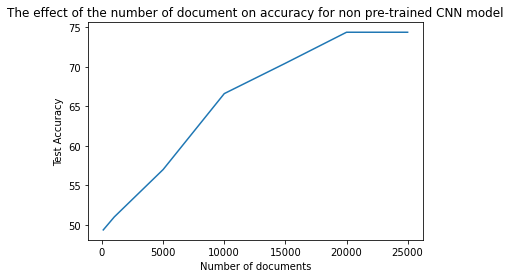

In [ ]:
plt.plot(res_size, res_acc)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for non pre-trained CNN model")
plt.show()

### Pre trained model and fine-tuned

In [ ]:
def doc_compare(number_of_files, min_freq=2,num_epochs = 5, early_stopping = True):
    
    training_dataset = TextClassificationDataset(train_f[:number_of_files], train_c[:number_of_files],min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    print("vocabulary size : ",len(training_word2idx))
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model =  CNNModel(embeddings = GloveEmbeddings)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999)) 
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))


    return test_acc,number_of_files

In [ ]:
res_acc=[]
res_size = []
for nb_files in [100,1000,5000,10000,15000,20000,25000] : 
    print("Number of documents : ",nb_files)
    acc, size = doc_compare(nb_files)
    res_acc.append(acc)
    res_size.append(size)


Number of documents :  100
vocabulary size :  1886
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.8400729006528854; Validation acc = 50.24
Epoch 2:
Epoch 2 : Validation loss = 0.7065360558032989; Validation acc = 51.44
Epoch 3:
Epoch 3 : Validation loss = 0.7090814572572708; Validation acc = 49.84
Early stopping.
Epoch 3 : Test loss = 0.7117868500947953; Test acc = 50.6
Number of documents :  1000
vocabulary size :  10879
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.6993868935108185; Validation acc = 49.88
Epoch 2:
Epoch 2 : Validation loss = 0.6973586165904999; Validation acc = 50.96
Epoch 3:
Epoch 3 : Validation loss = 0.6860819947719574; Validation acc = 57.2
Epoch 4:
Epoch 4 : Validation loss = 0.683758391737938; Validation acc = 60.2
Epoch 5:
Epoch 5 : Validation loss = 0.6731149411201477; Validation acc = 61.64
Epoch 5 : Test loss = 0.6649391904473305; Test acc = 61.88
Number of documents :  5000
vocabulary size :  28203
Beginning training...
Epoch 1

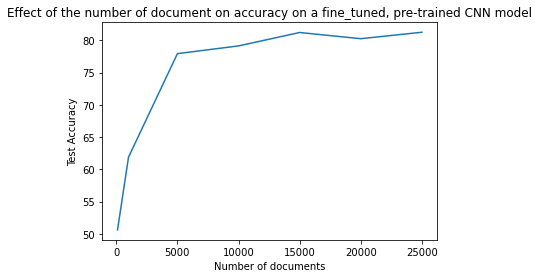

In [ ]:
plt.plot(res_size, res_acc)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("Effect of the number of document on accuracy on a fine_tuned, pre-trained CNN model")
plt.show()

### Pre trained model without fine-tuning

In [ ]:
def doc_compare(number_of_files, min_freq=2,num_epochs = 5, early_stopping = True):
    
    training_dataset = TextClassificationDataset(train_f[:number_of_files], train_c[:number_of_files],min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    print("vocabulary size : ",len(training_word2idx))
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model =  CNNModel(embeddings = GloveEmbeddings,no_fine_tuning = True)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999)) 
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))


    return test_acc,number_of_files

In [ ]:
res_acc=[]
res_size = []
for nb_files in [100,1000,5000,10000,15000,20000,25000] : 
    print("Number of documents : ",nb_files)
    acc, size = doc_compare(nb_files)
    res_acc.append(acc)
    res_size.append(size)

Number of documents :  100
vocabulary size :  1886
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.7780500036478043; Validation acc = 50.28
Epoch 2:
Epoch 2 : Validation loss = 0.7499549329280853; Validation acc = 50.32
Epoch 3:
Epoch 3 : Validation loss = 0.7548977696895599; Validation acc = 50.0
Early stopping.
Epoch 3 : Test loss = 0.7499304682016372; Test acc = 50.4
Number of documents :  1000
vocabulary size :  10879
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.6965560895204544; Validation acc = 50.88
Epoch 2:
Epoch 2 : Validation loss = 0.708443021774292; Validation acc = 52.12
Early stopping.
Epoch 2 : Test loss = 0.714998305439949; Test acc = 49.72
Number of documents :  5000
vocabulary size :  28203
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.6833689731359481; Validation acc = 50.64
Epoch 2:
Epoch 2 : Validation loss = 0.6485039836168289; Validation acc = 60.28
Epoch 3:
Epoch 3 : Validation loss = 0.5416684052348137; Validation acc

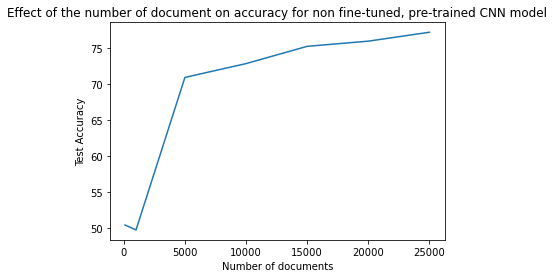

In [ ]:
plt.plot(res_size, res_acc)
plt.xlabel('Number of documents')
plt.ylabel('Test Accuracy')
plt.title("Effect of the number of document on accuracy for non fine-tuned, pre-trained CNN model")
plt.show()

## Comments on number of documents

From the obtained plots, it is apparent that the pre-trained models are less dependant from the number of document then the classical embedding models, where we can see them be close to their maximum accuracy for a relatively low number of documents (approximately 5000) compared to the other model. This is due to the fact that the embedding layer is pre-trained on a large corpus, therefore, does not need a lot of documents to build a good representation of the words.

## Impact of the size of the vocabulary

This time, we proceed by testing the impact of the size of the vocabulary by varying the count threshhold, where we start with a low count threshhold, which builds a rich vocabulary, and restrain it by increasing this threshhold. We consider all the documents for this task.

### Not pre-trained model

In [ ]:
def compare_vocab(min_freq=2, num_epochs = 5, early_stopping = True):
    training_dataset = TextClassificationDataset(train_f, train_c,min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    model = CNNModel(256, len(training_word2idx),None)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))


    return test_acc,len(training_word2idx)

In [ ]:
res_acc=[]
res_size = []
for min_freq in [2,5,10,20,100,200] : 
    print("min_freq : ",min_freq)
    acc, size = compare_vocab(min_freq)
    res_acc.append(acc)
    res_size.append(size)

min_freq :  2
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.5861328798532486; Validation acc = 68.76
Epoch 2:
Epoch 2 : Validation loss = 0.5774296534061432; Validation acc = 73.2
Epoch 3:
Epoch 3 : Validation loss = 0.7131867311894894; Validation acc = 75.24
Early stopping.
Epoch 3 : Test loss = 0.7120954193174839; Test acc = 75.04
min_freq :  5
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.586004790365696; Validation acc = 67.52
Epoch 2:
Epoch 2 : Validation loss = 0.5923625254631042; Validation acc = 73.16
Early stopping.
Epoch 2 : Test loss = 0.577078428864479; Test acc = 73.64
min_freq :  10
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.5836719152331352; Validation acc = 68.24
Epoch 2:
Epoch 2 : Validation loss = 0.5837490975856781; Validation acc = 73.56
Early stopping.
Epoch 2 : Test loss = 0.5886551584303379; Test acc = 73.48
min_freq :  20
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.6060612362623214; Validation acc 

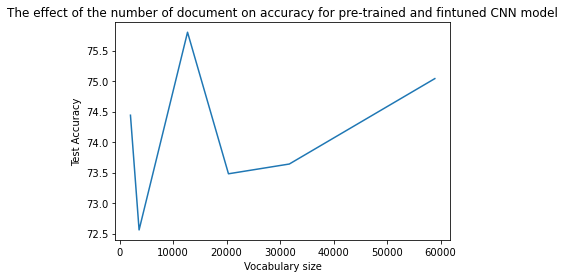

In [ ]:
plt.plot(res_size, res_acc)
plt.xlabel('Vocabulary size')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for pre-trained and fintuned CNN model")
plt.show()

### Pre-trained model with finetuning

In [ ]:
def compare_vocab(min_freq=2, num_epochs = 5, early_stopping = True):
    training_dataset = TextClassificationDataset(train_f, train_c,min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model =  CNNModel(embeddings = GloveEmbeddings)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999)) 
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))


    return test_acc,len(training_word2idx)

In [ ]:
res_acc=[]
res_size = []
for min_freq in [2,5,10,20,100,200] : 
    print("min_freq : ",min_freq)
    acc, size = compare_vocab(min_freq)
    res_acc.append(acc)
    res_size.append(size)

min_freq :  2
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.4197290936112404; Validation acc = 80.6
Epoch 2:
Epoch 2 : Validation loss = 0.4248141684383154; Validation acc = 81.52
Early stopping.
Epoch 2 : Test loss = 0.4082941138744354; Test acc = 82.8
min_freq :  5
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.44078025057911874; Validation acc = 79.24
Epoch 2:
Epoch 2 : Validation loss = 0.4079608109593391; Validation acc = 81.36
Epoch 3:
Epoch 3 : Validation loss = 0.4719274215400219; Validation acc = 80.48
Early stopping.
Epoch 3 : Test loss = 0.46916236221790314; Test acc = 81.68
min_freq :  10
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.646539318561554; Validation acc = 67.68
Epoch 2:
Epoch 2 : Validation loss = 0.41889016404747964; Validation acc = 81.64
Epoch 3:
Epoch 3 : Validation loss = 0.43441498540341855; Validation acc = 80.8
Early stopping.
Epoch 3 : Test loss = 0.41182470962405204; Test acc = 81.64
min_freq :  20
Beginning 

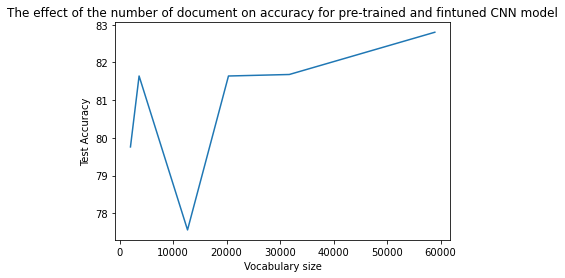

In [ ]:
plt.plot(res_size, res_acc)
plt.xlabel('Vocabulary size')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for pre-trained and finetuned CNN model")
plt.show()

### Pre-trained model without fine-tuning

In [ ]:
def compare_vocab(min_freq=2, num_epochs = 5, early_stopping = True):
    training_dataset = TextClassificationDataset(train_f, train_c,min_freq = min_freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()
    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))
    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)
    model =  CNNModel(embeddings = GloveEmbeddings,no_fine_tuning = True)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999)) 
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)#valid_dataloader
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))


    return test_acc,len(training_word2idx)

min_freq :  2
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.5349540641903877; Validation acc = 72.88
Epoch 2:
Epoch 2 : Validation loss = 0.5416274479031563; Validation acc = 72.48
Early stopping.
Epoch 2 : Test loss = 0.5273475393652916; Test acc = 73.04
min_freq :  5
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.5150906148552895; Validation acc = 74.72
Epoch 2:
Epoch 2 : Validation loss = 0.5065351262688637; Validation acc = 75.08
Epoch 3:
Epoch 3 : Validation loss = 0.5146688565611839; Validation acc = 74.88
Early stopping.
Epoch 3 : Test loss = 0.5117296847701073; Test acc = 75.0
min_freq :  10
Beginning training...
Epoch 1:
Epoch 1 : Validation loss = 0.692631620168686; Validation acc = 50.72
Epoch 2:
Epoch 2 : Validation loss = 0.6012147554755211; Validation acc = 69.68
Epoch 3:
Epoch 3 : Validation loss = 0.5133926343917846; Validation acc = 74.32
Epoch 4:
Epoch 4 : Validation loss = 0.48913553476333615; Validation acc = 75.88
Epoch 5:
Epoch 5 : Val

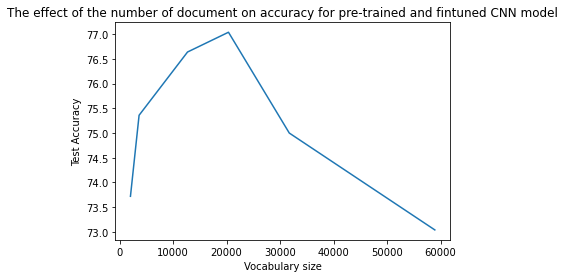

In [ ]:
res_acc=[]
res_size = []
for min_freq in [2,5,10,20,100,200] : 
    print("min_freq : ",min_freq)
    acc, size = compare_vocab(min_freq)
    res_acc.append(acc)
    res_size.append(size)
plt.plot(res_size, res_acc)
plt.xlabel('Vocabulary size')
plt.ylabel('Test Accuracy')
plt.title("The effect of the number of document on accuracy for pre-trained and non finetuned CNN model")
plt.show()

## Comments on the impact of the vocabulary size on model's performance.

We can note that for the classical embedding and non finetuned model, the accuracy increases with the size of the vocabulary, until it reaches it's maximum value, then starts decreasing. This is not the case for the fine tuned model, where it reaches it's maximum values for the maximum size of the vocabulary considered.
For the non fine-tuned model, the performance increases faster, but keeps a values close to it's maximum if we keep increasing the size.
In terms of performance, the best model is the fine-tuned model which achieves the best test accuracy of 82.8%.
We have the classical embedding model which achieves approximately 75.75% for the best test accuracy.
Finally the non fine tuned model peaks at 77% test accuracy.